In [326]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [327]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import pickle
import torch
from sklearn.metrics import auc

from matplotlib import rcParams
rcParams.update({'font.size': 16})

pd.options.display.float_format = '{:.4f}'.format

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
# rc('text', usetex=True)

np.random.seed(42)

# Globals

In [328]:
# Load image and mask data
with open("/hdd0/projects/regex/evals/images_and_masks.pkl", 'rb') as f:
    images_and_masks = pickle.load(f)
methods = ["IoU (q=0.1)", "IoU (q=0.05)", "IoU (q=0.025)", "mAP"]
result_index = ["k", "method", "level", "metric", "value"]
mri_modality = 2

# Test random attributions

330


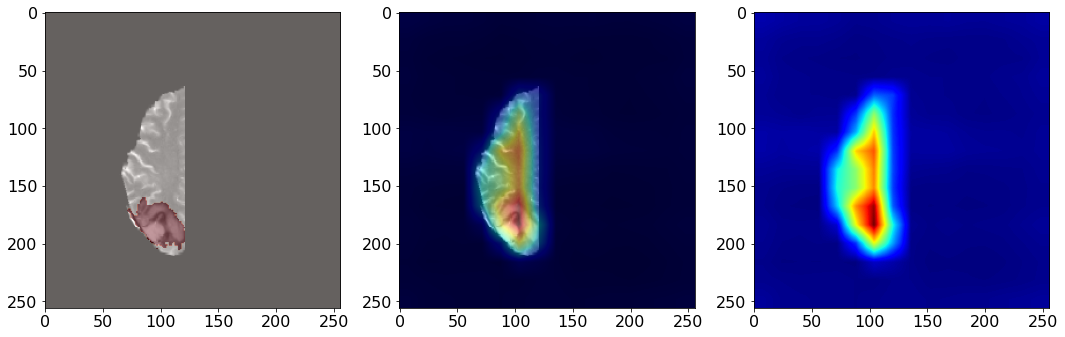

In [343]:
with open("/hdd0/projects/regex/evals/ensemble_attrs/k=4_vit_attrs_level=3.pkl", 'rb') as f:
    attrs = pickle.load(f)
idx = np.random.randint(0, len(images_and_masks))
# idx = 455
print(idx)
fig, ax = plt.subplots(1, 3, figsize=(18,10))
image, label, mask = images_and_masks[idx]
ax[0].imshow(image[mri_modality], cmap="gray")
ax[0].imshow(mask, cmap="Reds", alpha=0.4)
ax[1].imshow(image[mri_modality], cmap="gray")
ax[1].imshow(cv2.resize(attrs[idx][0].numpy(), (256,256)), cmap="jet", alpha=0.4)
ax[2].imshow(attrs[idx][0], cmap="jet")

# Load data

In [389]:
result_dir = "/hdd0/projects/regex/evals/ensemble_results"
results = os.listdir(result_dir)
result_df = pd.DataFrame(columns=result_index)
for result in results:
    k, method, level, metric = re.search(r"k=([0-9]+)_method=([^\_]+)_level=([0-9]+)__(.+).pkl", result).groups()
    with open(os.path.join(result_dir, result), 'rb') as f:
        value = pickle.load(f)
        result_df = result_df.append({"k": k, "method": method, "level": level, "metric": metric, "value": value}, ignore_index=True)

In [398]:
t1 = result_df[result_df['level'] == '4'].groupby(["method", "metric"], as_index=False).mean().pivot(index=['metric'], columns=['method'], values=['value']) * 100
t1 = t1.applymap(lambda x: f"{x:.2f}")
t1.columns = [col[1] for col in t1.columns]
t1 = t1[["DeepLIFT", "InputXGradients", "GradCAM", "ViT", "Baseline", "Marginal"]]
t1

,DeepLIFT,InputXGradients,GradCAM,ViT,Baseline,Marginal
metric,,,,,,
map,55.66,39.58,45.04,52.40,41.44,76.16
qiou_q=0.025,40.24,27.51,23.78,26.63,23.65,46.17
qiou_q=0.05,33.38,23.51,31.87,34.28,29.19,51.29
qiou_q=0.1,20.93,16.10,29.41,32.95,26.09,34.64


In [399]:
t2 = result_df[result_df['level'] == '4'].groupby(["method", "metric"], as_index=False).std().pivot(index=['metric'], columns=['method'], values=['value']) * 100
t2 = t2.applymap(lambda x: f"{x:.2f}")
t2.columns = [col[1] for col in t2.columns]
t2 = t2[["DeepLIFT", "InputXGradients", "GradCAM", "ViT", "Baseline", "Marginal"]]
t2

,DeepLIFT,InputXGradients,GradCAM,ViT,Baseline,Marginal
metric,,,,,,
map,nan,nan,nan,4.18,10.01,3.80
qiou_q=0.025,nan,nan,nan,3.20,5.55,1.74
qiou_q=0.05,nan,nan,nan,2.51,5.64,2.76
qiou_q=0.1,nan,nan,nan,0.94,4.07,2.08


In [400]:
print((t1 + "+/-" + t2).to_latex())

\begin{tabular}{lllllll}
\toprule
{} &     DeepLIFT & InputXGradients &      GradCAM &           ViT &       Baseline &      Marginal \\
metric       &              &                 &              &               &                &               \\
\midrule
map          &  55.66+/-nan &     39.58+/-nan &  45.04+/-nan &  52.40+/-4.18 &  41.44+/-10.01 &  76.16+/-3.80 \\
qiou\_q=0.025 &  40.24+/-nan &     27.51+/-nan &  23.78+/-nan &  26.63+/-3.20 &   23.65+/-5.55 &  46.17+/-1.74 \\
qiou\_q=0.05  &  33.38+/-nan &     23.51+/-nan &  31.87+/-nan &  34.28+/-2.51 &   29.19+/-5.64 &  51.29+/-2.76 \\
qiou\_q=0.1   &  20.93+/-nan &     16.10+/-nan &  29.41+/-nan &  32.95+/-0.94 &   26.09+/-4.07 &  34.64+/-2.08 \\
\bottomrule
\end{tabular}



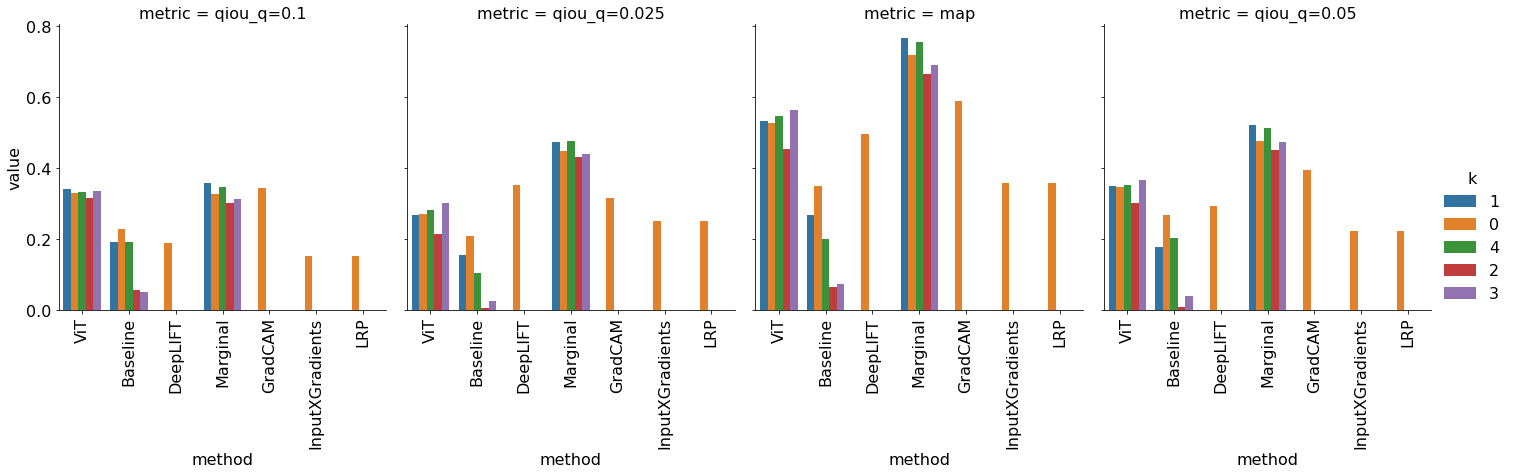

In [337]:
df3 = result_df[result_df['level'] == '3']
g = sns.catplot(x="method", y="value",
                hue="k", col="metric",
                data=df3, kind="bar")
g.set_xticklabels(rotation=90)

In [319]:
result_df.groupby(['method', "level", "metric"]).mean()

value
method          level metric             
Baseline        3     map          0.1876
                      qiou_q=0.025 0.0977
                      qiou_q=0.05  0.1382
                      qiou_q=0.1   0.1432
DeepLIFT        3     map          0.4940
                      qiou_q=0.025 0.3518
                      qiou_q=0.05  0.2920
                      qiou_q=0.1   0.1878
GradCAM         3     map          0.5868
                      qiou_q=0.025 0.3159
                      qiou_q=0.05  0.3934
                      qiou_q=0.1   0.3420
InputXGradients 3     map          0.3561
                      qiou_q=0.025 0.2512
                      qiou_q=0.05  0.2203
                      qiou_q=0.1   0.1518
LRP             3     map          0.3561
                      qiou_q=0.025 0.2512
                      qiou_q=0.05  0.2203
                      qiou_q=0.1   0.1518
Marginal        3     map          0.7412
                      qiou_q=0.025 0.4598
                      qiou_q=0.05  0.4985
                      qiou_q=0.1   0.3271
ViT             3     map          0.5240
                      qiou_q=0.025 0.2663
                      qiou_q=0.05  0.3428
                      qiou_q=0.1   0.3293
                4     map          0.5222
                      qiou_q=0.025 0.2662
                      qiou_q=0.05  0.3413
                      qiou_q=0.1   0.3260

In [320]:
result_df.groupby(['method', "level", "metric"]).std()

value
method          level metric             
Baseline        3     map          0.1422
                      qiou_q=0.025 0.0991
                      qiou_q=0.05  0.1112
                      qiou_q=0.1   0.0843
DeepLIFT        3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
GradCAM         3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
InputXGradients 3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
LRP             3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
Marginal        3     map          0.0349
                      qiou_q=0.025 0.0186
                      qiou_q=0.05  0.0317
                      qiou_q=0.1   0.0287
ViT             3     map          0.0418
                      qiou_q=0.025 0.0320
                      qiou_q=0.05  0.0251
                      qiou_q=0.1   0.0108
                4     map          0.0480
                      qiou_q=0.025 0.0370
                      qiou_q=0.05  0.0287
                      qiou_q=0.1   0.0106

# Table

In [25]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=1.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results1 = pd.DataFrame(results_dict, index=methods)
# results1.pop("Solver Attention")
results1*100

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),43.81,15.00,13.69,15.00,29.34,NaN,32.51
IoU (q=0.05),53.57,22.34,19.57,22.34,31.18,NaN,36.11
IoU (q=0.025),44.07,25.00,23.03,25.00,24.12,NaN,26.67
mAP,73.83,34.09,32.09,34.09,45.50,NaN,49.08


In [26]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=2.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results2 = pd.DataFrame(results_dict, index=methods) * 100
results2
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),40.52,15.10,16.67,15.10,38.83,NaN,38.30
IoU (q=0.05),57.41,22.67,23.51,22.67,50.17,NaN,48.18
IoU (q=0.025),51.14,25.66,26.29,25.66,40.78,NaN,38.74
mAP,85.20,35.33,37.56,35.33,71.34,NaN,68.03


In [27]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=3.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results3 = pd.DataFrame(results_dict, index=methods) * 100
results3

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),35.95,15.13,18.22,15.13,30.91,17.11,32.59,41.41
IoU (q=0.05),49.07,22.88,26.22,22.88,31.93,16.76,40.53,52.46
IoU (q=0.025),46.58,26.72,29.33,26.72,23.66,13.63,34.12,46.07
mAP,74.60,37.18,42.50,37.18,46.91,16.61,58.93,78.31


In [28]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100
results4
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.33,15.55,20.39,15.55,30.91,36.24,NaN,36.56
IoU (q=0.05),18.23,23.61,29.98,23.61,31.93,42.81,NaN,48.65
IoU (q=0.025),25.95,28.12,32.95,28.12,23.66,36.09,NaN,43.15
mAP,31.76,39.21,47.95,39.21,46.91,66.03,NaN,74.85


## Level 3 segmentation

In [29]:
results3.transpose()

,IoU (q=0.1),IoU (q=0.05),IoU (q=0.025),mAP
GradCAM,35.95,49.07,46.58,74.60
InputXGradients,15.13,22.88,26.72,37.18
DeepLIFT,18.22,26.22,29.33,42.50
LRP,15.13,22.88,26.72,37.18
ViT Attention,30.91,31.93,23.66,46.91
Baseline Attention,17.11,16.76,13.63,16.61
Solver Attention,32.59,40.53,34.12,58.93
Marginal Attention,41.41,52.46,46.07,78.31


In [30]:
print(results3.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &   LRP &  ViT Attention &  Baseline Attention &  Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &    35.95 &            15.13 &     18.22 & 15.13 &          30.91 &               17.11 &             32.59 &               41.41 \\
IoU (q=0.05)  &    49.07 &            22.88 &     26.22 & 22.88 &          31.93 &               16.76 &             40.53 &               52.46 \\
IoU (q=0.025) &    46.58 &            26.72 &     29.33 & 26.72 &          23.66 &               13.63 &             34.12 &               46.07 \\
mAP           &    74.60 &            37.18 &     42.50 & 37.18 &          46.91 &               16.61 &             58.93 &               78.31 \\
\bottomrule
\end{tabular}



In [31]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100

## Level 4 segmentation

In [32]:
results4

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.33,15.55,20.39,15.55,30.91,36.24,NaN,36.56
IoU (q=0.05),18.23,23.61,29.98,23.61,31.93,42.81,NaN,48.65
IoU (q=0.025),25.95,28.12,32.95,28.12,23.66,36.09,NaN,43.15
mAP,31.76,39.21,47.95,39.21,46.91,66.03,NaN,74.85


In [12]:
print(results4.to_latex())

\begin{tabular}{lrrrrrlr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &   LRP &  Baseline Attention & Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &    11.33 &            15.55 &     20.39 & 15.55 &               36.24 &              NaN &               36.56 \\
IoU (q=0.05)  &    18.23 &            23.61 &     29.98 & 23.61 &               42.81 &              NaN &               48.65 \\
IoU (q=0.025) &    25.95 &            28.12 &     32.95 & 28.12 &               36.09 &              NaN &               43.15 \\
mAP           &    31.76 &            39.21 &     47.95 & 39.21 &               66.03 &              NaN &               74.85 \\
\bottomrule
\end{tabular}



In [13]:
pd.MultiIndex.from_frame(results4)

MultiIndex([(11.330933988097739, 15.552943601779177, 20.392698359956807, ...),
            (18.234379417574516,  23.61326760887862, 29.980217578497857, ...),
            ( 25.95239315148619, 28.116972887996607,  32.94651971367122, ...),
            (31.755127198636895,  39.20930917639272,   47.9463297775212, ...)],
           names=['GradCAM', 'InputXGradients', 'DeepLIFT', 'LRP', 'Baseline Attention', 'Solver Attention', 'Marginal Attention'])

# Images with heatmaps

In [438]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from torchvision.transforms import InterpolationMode
from kornia.augmentation import Normalize
from dataio.dataloader import probe_data_folder, BraTS18Binary
    
# Load attribution data
level = 3
method_names = [
    ("DeepLIFT", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_dl_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_dl_attrs_level=4.pkl"),
    ("LRP", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_lrp_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_lrp_attrs_level=4.pkl"),
    ("GradCAM", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_gc_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_gc_attrs_level=4.pkl"), 
    ("ViT-B/16", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_vit_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_vit_attrs_level=4.pkl"),
    ("Baseline", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_baseline_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_baseline_attrs_level=4.pkl"),
    ("Marginal", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_marginal_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_marginal_attrs_level=4.pkl"),
]

methods = []
for name, filename3, filename4 in method_names:
    with open(filename3, 'rb') as f:
        file3 = pickle.load(f)
    with open(filename4, 'rb') as f:
        file4 = pickle.load(f)
    methods.append((name, file3, file4))
# results.pop("Solver Attention")

In [439]:
# samples = np.random.randint(0, high=len(images_and_masks), size=5)
# samples = [1899, 1297, 2062, 1955, 870, 161, 502, 763, 1367, 2088]
samples = [900]
print(samples)

[900]


<ipython-input-440-c47ad6e8f54b>:39: UserWarning: No contour levels were found within the data range.
  mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])


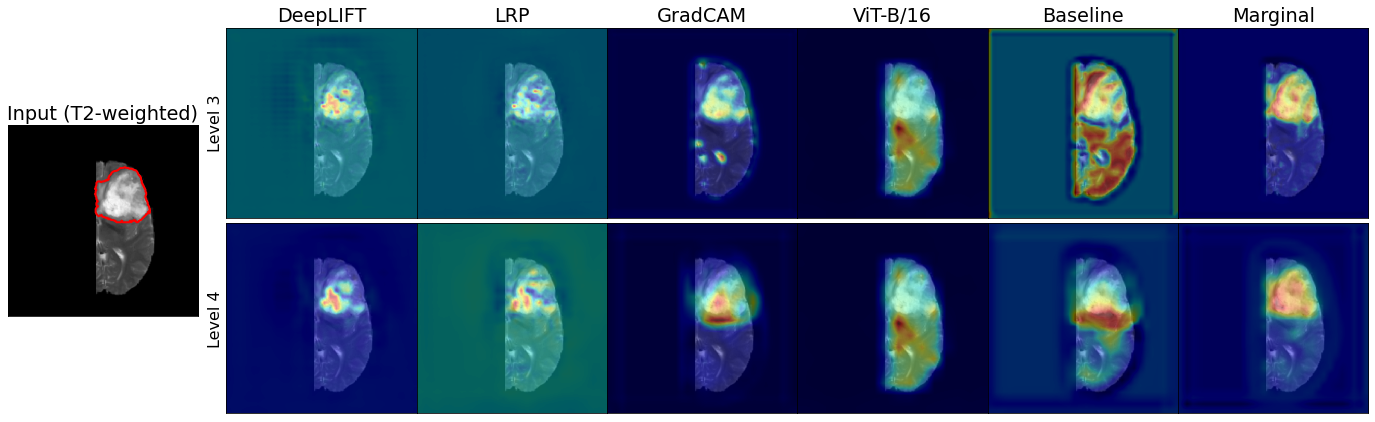

In [440]:
fig = plt.figure(figsize=(3*(len(methods)+1), 2*3*len(samples)))
gs = gridspec.GridSpec(nrows=2*len(samples), 
                       ncols=len(methods)+1+1, 
                       left=0.05, 
                       bottom=0.05, 
                       right=0.95, 
                       top=0.95, 
                       wspace=0.0, 
                       hspace=0.01,
                       width_ratios=[1,0.15, *list([1 for i in methods])])

# Set mri image col
mri_col = []
i = 0
for _ in range(len(samples)):
    ax = plt.subplot(gs[i:i+2, 0])
    mri_col.append(ax)
    i += 2

# Set blank image col
blank_col = []
for i in range(2*len(samples)):
    ax = plt.subplot(gs[i, 1])
    blank_col.append(ax)
    
# Set attributions matrix
matrix = []
for i in range(2*len(samples)):
    row = []
    for j in range(len(methods)):
        ax = plt.subplot(gs[i, j+2])
        row.append(ax)
    matrix.append(row)

# Plot mri images
for mri_ax, sample_idx in zip(mri_col, samples):
    image, label, mask = images_and_masks[sample_idx]
    mri_ax.imshow(image[mri_modality], cmap="gray")
    mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])

# Plot attribution
running_idx = 0
for i in range(0, 2*len(samples), 2):
    idx = samples[running_idx]
    image, label, mask = images_and_masks[idx]
    for j in range(len(methods)):
        attr3 = methods[j][1][idx][0]
        attr3 = cv2.resize(attr3.numpy(), (256, 256), interpolation=cv2.INTER_LINEAR)
        attr4 = methods[j][2][idx][0]
        attr4 = cv2.resize(attr4.numpy(), (256, 256), interpolation=cv2.INTER_LINEAR)
        matrix[i][j].imshow(image[mri_modality], cmap="gray")
        matrix[i][j].imshow(attr3, cmap="jet", alpha=0.4)
        matrix[i+1][j].imshow(image[mri_modality], cmap="gray")
        matrix[i+1][j].imshow(attr4, cmap="jet", alpha=0.4)
    running_idx += 1

# Set titles
mri_col[0].set_title(f"Input (T2-weighted)")
for j, ax in enumerate(matrix[0]):
    ax.set_title(methods[j][0])
    
for i, row in enumerate(matrix):
    if i % 2 == 0:
        row[0].set_ylabel("$\tau^3$", labelpad=0.0)
    else:
        row[0].set_ylabel("$\tau^4$", labelpad=0.0)
        
for ax in mri_col:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    
for ax in blank_col:
    ax.axis("off")
    
for row in matrix:
    for ax in row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', which='both', length=0)